In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import OneHotEncoder

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow import keras

from IPython.display import clear_output

In [3]:
df = pd.read_json('train_data.json')
df = df.drop(columns=['de'])

,residence_1_2_years,residence_3_years,residence_6_months_or_less,residence_7_12_months,bank_1_2_years,bank_3_years,bank_6_months_or_less,bank_7_12_months,monthly_income,monthly_rent,...,score_lexisnexis,score_serasa,score_unit4,credit_line_requested,credit_line_approved,app_req_ratio,compliant,monthly_spend,time_as_client,profit
0,0,0,1,0,0,1,0,0,2.004321,2.978181,...,0.489796,0.12750,0.524876,3.176381,3.041787,0.957627,1,1.000000,102,18.36
1,0,1,0,0,0,1,0,0,4.021231,3.380392,...,0.765306,0.11125,0.483831,4.406557,4.396217,0.997653,1,3.442793,102,5652.84
2,1,0,0,0,0,1,0,0,3.886547,2.004321,...,0.538776,0.83750,0.269900,3.954291,3.908539,0.988430,1,2.938019,102,1766.64
3,0,1,0,0,0,0,1,0,3.477266,0.000000,...,1.000000,0.38125,0.500000,3.740442,3.662852,0.979257,1,2.952792,102,1827.84
5,1,0,0,0,0,0,1,0,3.995679,2.954725,...,0.000000,0.30500,0.521144,4.484314,4.474231,0.997751,0,2.771587,1,-578.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9215,0,1,0,0,0,1,0,0,3.518646,3.518646,...,0.987755,0.01375,0.636816,4.000043,3.968530,0.992122,1,1.544068,102,69.36
9216,0,1,0,0,0,0,0,1,4.161398,3.389343,...,0.922449,0.00000,0.844527,3.653309,3.431525,0.939292,1,3.197556,102,3213.00
9217,0,1,0,0,1,0,0,0,3.579898,3.146438,...,0.132653,0.00000,0.259950,3.176381,3.079543,0.969513,1,2.733197,102,1101.60
9218,0,1,0,0,0,1,0,0,2.778874,2.399674,...,0.800000,0.04750,0.726368,3.176381,3.041787,0.957627,1,2.459392,102,585.48


In [4]:
validation_df = df.sample(frac=0.2, random_state=12)
train_df = df.drop(validation_df.index)
print(f"Using {len(train_df)} samples for training and {len(validation_df)} for validation")

Using 6531 samples for training and 1633 for validation


In [5]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("defaulted")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds = dataframe_to_dataset(train_df)
val_ds = dataframe_to_dataset(validation_df)

KeyError: 'defaulted'

In [21]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [22]:
from keras.utils import FeatureSpace
import re
features = {f:"float_normalized" for f in df.columns.drop('defaulted')}
feature_space = FeatureSpace(features = features)
train_ds_with_no_labels = train_ds.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

In [23]:
for x, _ in train_ds.take(1):
    preprocessed_x = feature_space(x)
    print("preprocessed_x.shape:", preprocessed_x.shape)
    print("preprocessed_x.dtype:", preprocessed_x.dtype)

preprocessed_x.shape: (32, 21)
preprocessed_x.dtype: <dtype: 'float32'>


In [24]:
preprocessed_train_ds = train_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_train_ds = preprocessed_train_ds.prefetch(tf.data.AUTOTUNE)

preprocessed_val_ds = val_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_val_ds = preprocessed_val_ds.prefetch(tf.data.AUTOTUNE)

In [25]:
dict_inputs = feature_space.get_inputs()
encoded_features = feature_space.get_encoded_features()

x = keras.layers.Dense(32, activation="relu")(encoded_features)
# x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(16, activation="tanh")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(8, activation="relu")(x)
predictions = keras.layers.Dense(1, activation="sigmoid")(x)

training_model = keras.Model(inputs=encoded_features, outputs=predictions)
training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.Precision(),
                                                           tf.keras.metrics.Recall(),
                                                           tf.keras.metrics.FalseNegatives(),
                                                           tf.keras.metrics.FalsePositives(),
                                                           tf.keras.metrics.TrueNegatives(),
                                                           tf.keras.metrics.TruePositives(),
                                                           ])
training_model.save_weights('initial_model.h5')

inference_model = keras.Model(inputs=dict_inputs, outputs=predictions)

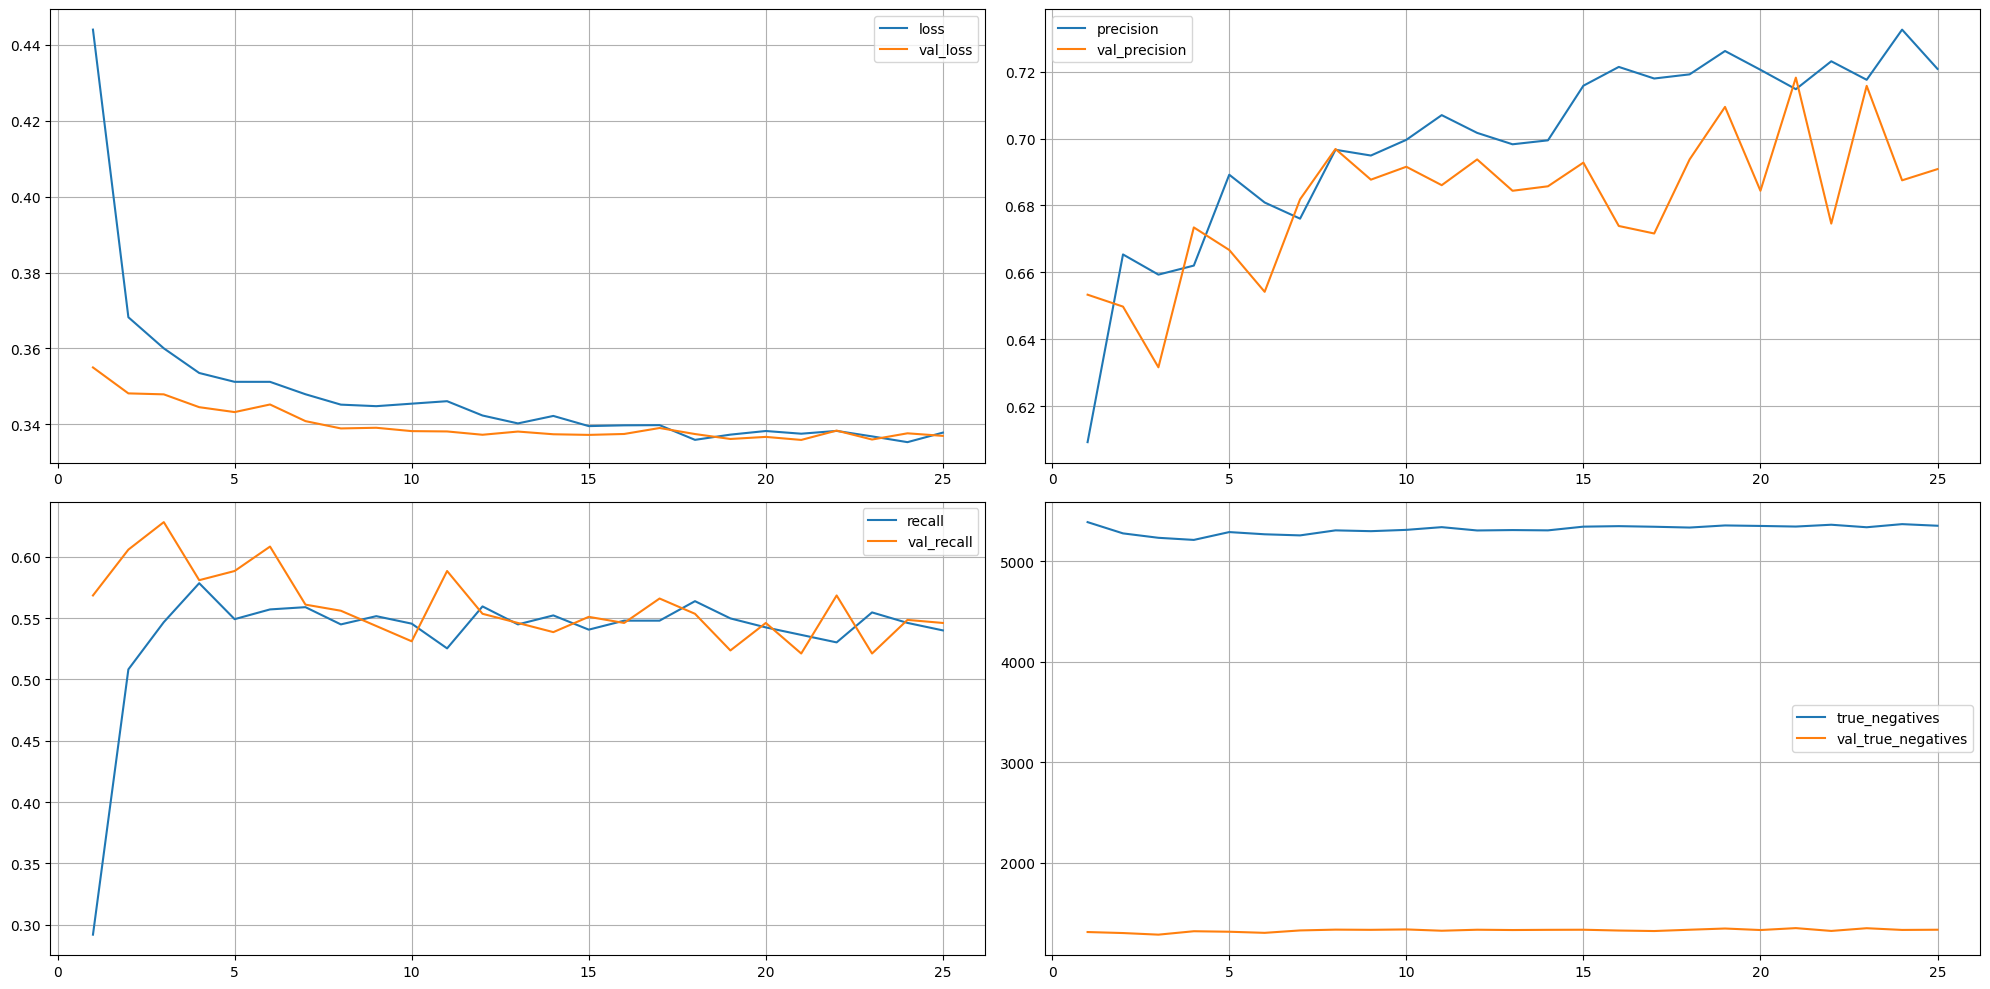

230/230 [==============================] - 1s 4ms/step - loss: 0.3378 - precision: 0.7208 - recall: 0.5401 - false_negatives: 752.0000 - false_positives: 342.0000 - true_negatives: 5354.0000 - true_positives: 883.0000 - val_loss: 0.3370 - val_precision: 0.6909 - val_recall: 0.5461 - val_false_negatives: 182.0000 - val_false_positives: 98.0000 - val_true_negatives: 1334.0000 - val_true_positives: 219.0000
CPU times: user 40.5 s, sys: 12.6 s, total: 53.1 s
Wall time: 27.7 s


In [26]:
%%time

metrics_to_plot = ['loss', 'precision', 'recall', 'true_negatives']

callbacks_list = [PlotLearning(metrics_to_plot)]

training_model.load_weights('initial_model.h5')

training_history = training_model.fit(preprocessed_train_ds, 
                                      epochs=25,
                                      validation_data=preprocessed_val_ds, 
                                      verbose=1,
                                      shuffle=True,
                                      # class_weight=class_weight,
                                      callbacks=callbacks_list)

In [27]:
training_model.metrics

In [28]:
FN = training_model.metrics[-4].result().numpy()
FP = training_model.metrics[-3].result().numpy()
TN = training_model.metrics[-2].result().numpy() 
TP = training_model.metrics[-1].result().numpy()

T = FN + FP + TN + TP
T

1833.0

In [29]:
(TN*1000*0.02 - FN*100)/(TN+FN)

5.593667546174142